In [13]:
%pip install --upgrade google-cloud-bigquery google-cloud-pubsub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 3.38.0
    Uninstalling google-cloud-bigquery-3.38.0:
      Successfully uninstalled google-cloud-bigquery-3.38.0


In [36]:
import os
import json
import time
from google.cloud import bigquery
from google.cloud import pubsub_v1

In [2]:
client = bigquery.Client()

PROJECT_ID = client.project
DATASET_ID = "geo_dataset"
LOCATION = "us"

# Create Dataset
dataset_ref = f"{PROJECT_ID}.{DATASET_ID}"

dataset = bigquery.Dataset(dataset_ref)
dataset.location = LOCATION

try:
    client.create_dataset(dataset, timeout=30)
    print(f"Dataset {DATASET_ID} created.")
except Conflict:
    print(f"Dataset {DATASET_ID} already exists.")



Dataset geo_dataset created.


In [32]:
TABLE_ID = "geo_table"

SUBSCRIPTION_ID = "geo-flight-sub"


In [12]:

# Initialize clients
bq_client = bigquery.Client(project=PROJECT_ID)
publisher = pubsub_v1.PublisherClient()
subscriber = pubsub_v1.SubscriberClient()

In [4]:
# Custom Schema
schema = [
 bigquery.SchemaField("MT", "STRING", mode="NULLABLE", description="SEL ID AIR STA CLK MSG info http://woodair.net/sbs/Article/Barebones42_Socket_Data.htm"),
 bigquery.SchemaField("TT", "INT64", mode="NULLABLE", description="1 - 8"),
 bigquery.SchemaField("SID", "STRING", mode="NULLABLE", description="Database Session record number"),
 bigquery.SchemaField("AID", "STRING", mode="NULLABLE", description="Database Aircraft record number"),
 bigquery.SchemaField("Hex", "STRING", mode="NULLABLE", description="Aircraft Mode S hexadecimal code https://opensky-network.org/datasets/metadata/"),
 bigquery.SchemaField("FID", "STRING", mode="NULLABLE", description="Database Flight record number"),
 bigquery.SchemaField("DMG", "DATE", mode="NULLABLE", description="Date message generated"),
 bigquery.SchemaField("TMG", "TIME", mode="NULLABLE", description="Time message generated"),
 bigquery.SchemaField("DML", "DATE", mode="NULLABLE", description="Date message logged"),
 bigquery.SchemaField("TML", "TIME", mode="NULLABLE", description="Time message logged"),
 bigquery.SchemaField("CS", "STRING", mode="NULLABLE", description="Callsign (flight number or registration)"),
 bigquery.SchemaField("Alt", "INT64", mode="NULLABLE", description="Mode C altitude (Flight Level)"),
 bigquery.SchemaField("GS", "INT64", mode="NULLABLE", description="Ground Speed"),
 bigquery.SchemaField("Trk", "INT64", mode="NULLABLE", description="Track"),
 bigquery.SchemaField("Lat", "FLOAT64", mode="NULLABLE", description="Latitude (N/E positive, S/W negative)"),
 bigquery.SchemaField("Lng", "FLOAT64", mode="NULLABLE", description="Longitude (N/E positive, S/W negative)"),
 bigquery.SchemaField("VR", "INT64", mode="NULLABLE", description="Vertical Rate"),
 bigquery.SchemaField("Sq", "STRING", mode="NULLABLE", description="Assigned Mode A squawk code"),
 bigquery.SchemaField("Alrt", "INT64", mode="NULLABLE", description="Flag to indicate squawk has changed"),
 bigquery.SchemaField("Emer", "INT64", mode="NULLABLE", description="Flag to indicate emergency code has been set"),
 bigquery.SchemaField("SPI", "INT64", mode="NULLABLE", description="Flag to indicate transponder Ident has been activated"),
 bigquery.SchemaField("Gnd", "INT64", mode="NULLABLE", description="Flag to indicate ground squat switch is active"),
]

In [14]:
# Create Table
table_ref = dataset.table(TABLE_ID)

table = bigquery.Table(table_ref, schema=schema)
table = bq_client.create_table(table, exists_ok=True)
print(f"Table {TABLE_ID} created with custom schema.")

Table geo_table created with custom schema.


In [29]:
!gcloud pubsub subscriptions create geo-flight-sub \
  --topic=projects/paul-leroy/topics/flight-transponder \
  --project=qwiklabs-gcp-01-5f9c2ba2a4cd


Created subscription [projects/qwiklabs-gcp-01-5f9c2ba2a4cd/subscriptions/geo-flight-sub].


In [49]:
## Test data pull

subscriber = pubsub_v1.SubscriberClient()

subscription_path = subscriber.subscription_path(PROJECT_ID, SUBSCRIPTION_ID)

response = subscriber.pull(
    request={
        "subscription": subscription_path,
        "max_messages": 10,
    }
)

for msg in response.received_messages:
    print(msg.message.data.decode("utf-8"))

MSG,5,1,1,405636,1,2026/01/15,21:39:40.662,2026/01/15,21:39:40.715,,4250,,,,,,,0,,0,
MSG,4,1,1,407E7B,1,2026/01/15,21:39:40.662,2026/01/15,21:39:40.715,,,329,318,,,-1856,,,,,0
MSG,5,1,1,4CAEE8,1,2026/01/15,21:39:40.663,2026/01/15,21:39:40.715,,10775,,,,,,,0,,0,
MSG,8,1,1,406544,1,2026/01/15,21:39:40.663,2026/01/15,21:39:40.715,,,,,,,,,,,,0
MSG,5,1,1,407464,1,2026/01/15,21:39:40.664,2026/01/15,21:39:40.715,,5425,,,,,,,0,,0,
MSG,5,1,1,4009D8,1,2026/01/15,21:39:40.665,2026/01/15,21:39:40.715,BAW749  ,4775,,,,,,,0,,0,
MSG,7,1,1,06A0E9,1,2026/01/15,21:39:40.669,2026/01/15,21:39:40.715,,4850,,,,,,,,,,
MSG,8,1,1,71C075,1,2026/01/15,21:39:40.670,2026/01/15,21:39:40.715,,,,,,,,,,,,0
MSG,8,1,1,4081BC,1,2026/01/15,21:39:40.670,2026/01/15,21:39:40.715,,,,,,,,,,,,0
MSG,8,1,1,4CA892,1,2026/01/15,21:39:40.671,2026/01/15,21:39:40.715,,,,,,,,,,,,0


In [50]:
def transform_row(raw_data):
    """
    Parses the raw string into the BigQuery schema.
    Sample: MSG,5,1,1,405636,1,2026/01/15,21:39:40.662,2026/01/15,21:39:40.715,,4250,,,,,,,0,,0,
    """
    if not raw_data:
        return None

    # Split the CSV string into a list
    parts = [p.strip() for p in raw_data.split(',')]

    def to_int(val):
        try:
            return int(float(val)) if val else None
        except (ValueError, TypeError):
            return None

    def to_float(val):
        try:
            return float(val) if val else None
        except (ValueError, TypeError):
            return None

    def clean_date(val):
        return val.replace('/', '-') if val else None

    def clean_time(val):
        return val[:8] if val else None

    # Mapping based on index positions
    return {
        "MT": parts[0] if len(parts) > 0 else None,
        "TT": to_int(parts[1]) if len(parts) > 1 else None,
        "SID": parts[2] if len(parts) > 2 else None,
        "AID": parts[3] if len(parts) > 3 else None,
        "Hex": parts[4] if len(parts) > 4 else None,
        "FID": parts[5] if len(parts) > 5 else None,
        "DMG": clean_date(parts[6]) if len(parts) > 6 else None,
        "TMG": clean_time(parts[7]) if len(parts) > 7 else None,
        "DML": clean_date(parts[8]) if len(parts) > 8 else None,
        "TML": clean_time(parts[9]) if len(parts) > 9 else None,
        "CS":  parts[10] if len(parts) > 10 and parts[10] else None,
        "Alt": to_int(parts[11]) if len(parts) > 11 else None,
        "GS":  to_int(parts[12]) if len(parts) > 12 else None,
        "Trk": to_int(parts[13]) if len(parts) > 13 else None,
        "Lat": to_float(parts[14]) if len(parts) > 14 else None,
        "Lng": to_float(parts[15]) if len(parts) > 15 else None,
        "VR":  to_int(parts[16]) if len(parts) > 16 else None,
        "Sq":  parts[17] if len(parts) > 17 and parts[17] else None,
        "Alrt": to_int(parts[18]) if len(parts) > 18 else None,
        "Emer": to_int(parts[19]) if len(parts) > 19 else None,
        "SPI":  to_int(parts[20]) if len(parts) > 20 else None,
        "Gnd":  to_int(parts[21]) if len(parts) > 21 else None,
    }

In [51]:
RUN_DURATION_SECONDS = 10

table_full_id = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"

subscriber = pubsub_v1.SubscriberClient()
bq_client = bigquery.Client(project=PROJECT_ID)

subscription_path = subscriber.subscription_path(PROJECT_ID, SUBSCRIPTION_ID)

print(f"Starting pull for {RUN_DURATION_SECONDS} seconds...")
start_time = time.time()
rows_to_insert = []
ack_ids = []

while (time.time() - start_time) < RUN_DURATION_SECONDS:
    # Pull messages from Pub/Sub
    response = subscriber.pull(
        request={
            "subscription": subscription_path,
            "max_messages": 1000,
        },
        timeout=5.0
    )

    if not response.received_messages:
        continue

    for msg in response.received_messages:
        try:
            # Parse and transform
            decoded_payload = msg.message.data.decode("utf-8")
            rows_to_insert.append(transform_row(decoded_payload))
            ack_ids.append(msg.ack_id)
        except Exception as e:
            print(f"Error parsing message: {e}")

    # Insert into BigQuery
    if rows_to_insert:
        errors = bq_client.insert_rows_json(table_full_id, rows_to_insert)

        if errors == []:
            print(f"Inserted batch of {len(rows_to_insert)} records.")

            subscriber.acknowledge(
                request={
                    "subscription": subscription_path,
                    "ack_ids": ack_ids,
                }
            )
        else:
            print(f"BigQuery Insert Errors: {errors}")

        # Clear lists for the next iteration
        rows_to_insert.clear()
        ack_ids.clear()

print("Duration reached. Stream closed.")

Starting pull for 10 seconds...
Inserted batch of 1000 records.
Inserted batch of 1000 records.
Inserted batch of 1000 records.
Inserted batch of 1000 records.
Inserted batch of 1000 records.
Inserted batch of 1000 records.
Inserted batch of 1000 records.
Duration reached. Stream closed.


In [52]:
%%bigquery flight_data
SELECT * FROM `qwiklabs-gcp-01-5f9c2ba2a4cd.geo_dataset.geo_table`;

Query is running:   0%|          |

Downloading:   0%|          |

In [53]:
flight_data.head()

,MT,TT,SID,AID,Hex,FID,DMG,TMG,DML,TML,...,GS,Trk,Lat,Lng,VR,Sq,Alrt,Emer,SPI,Gnd
0,MSG,1,1,1,4080E9,1,2026-01-15,21:16:48,2026-01-15,21:16:48,...,<NA>,<NA>,NaN,NaN,<NA>,None,<NA>,<NA>,<NA>,0
1,MSG,1,1,1,4BAAD0,1,2026-01-15,21:16:48,2026-01-15,21:16:48,...,<NA>,<NA>,NaN,NaN,<NA>,None,<NA>,<NA>,<NA>,0
2,MSG,1,1,1,407FC9,1,2026-01-15,21:16:48,2026-01-15,21:16:48,...,<NA>,<NA>,NaN,NaN,<NA>,None,<NA>,<NA>,<NA>,0
3,MSG,1,1,1,4BB219,1,2026-01-15,21:16:49,2026-01-15,21:16:49,...,<NA>,<NA>,NaN,NaN,<NA>,None,<NA>,<NA>,<NA>,0
4,MSG,1,1,1,8963D4,1,2026-01-15,21:16:49,2026-01-15,21:16:49,...,<NA>,<NA>,NaN,NaN,<NA>,None,<NA>,<NA>,<NA>,0


In [55]:
flight_data.shape

(7000, 22)

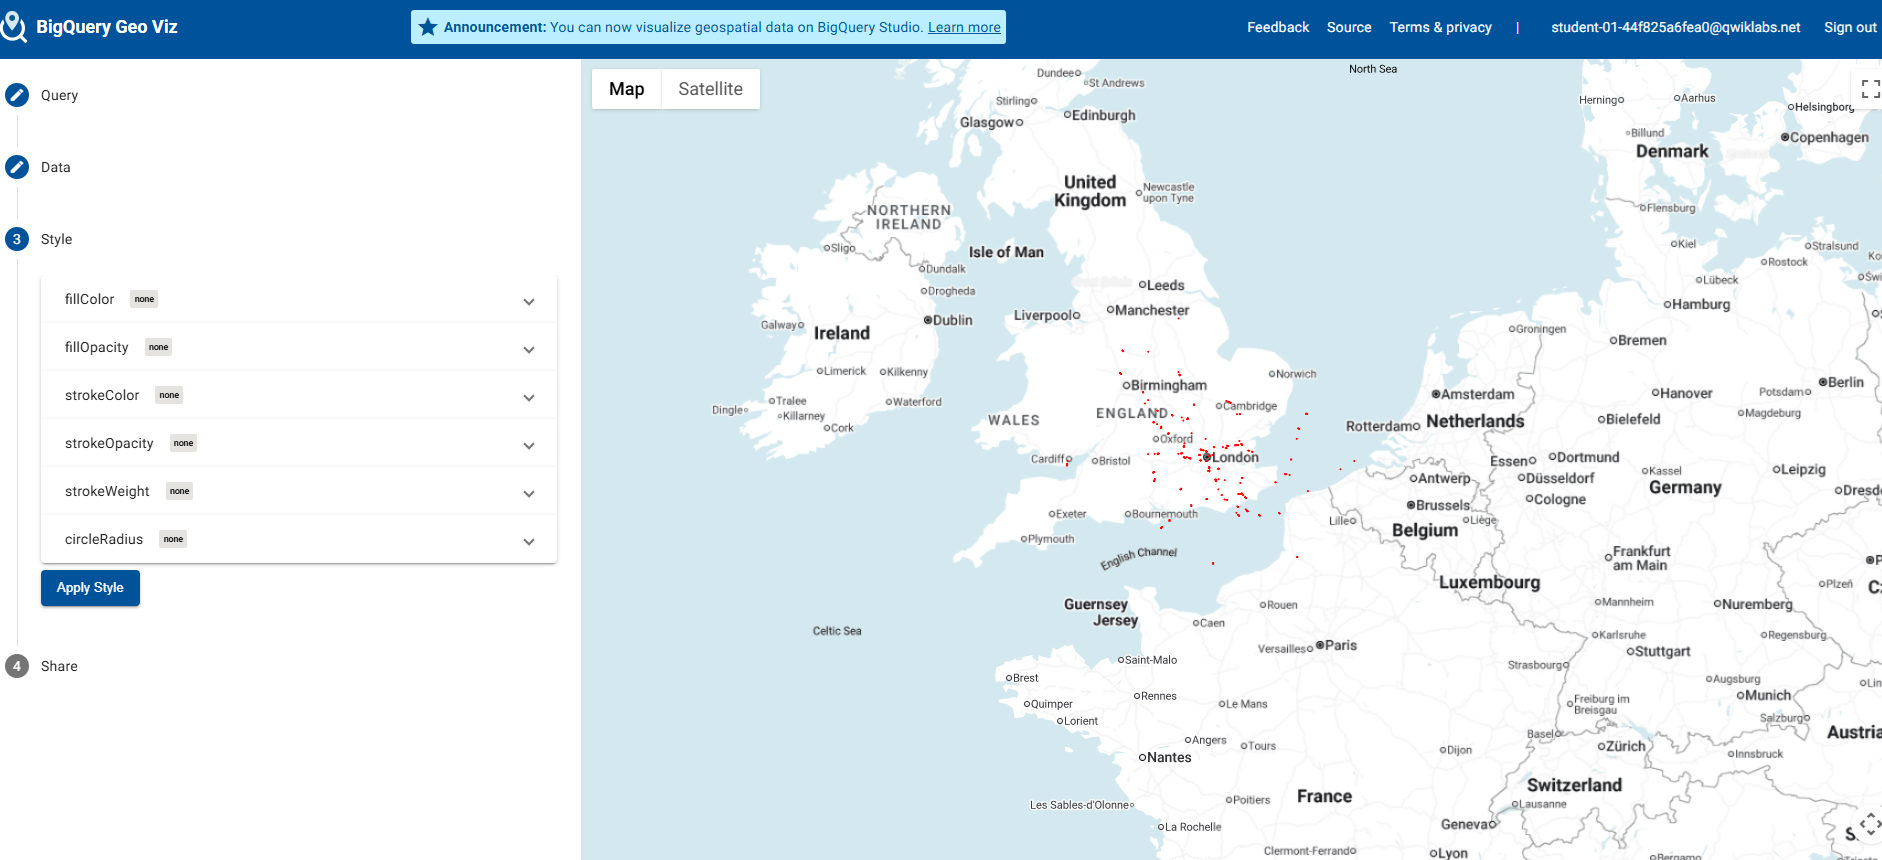